In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.utils import resample

warnings.filterwarnings('ignore')

# Charger les données
data = pd.read_csv('cc_fraud_detection.csv')

# Vérifier si les données sont bien chargées
print(f"Le dataset contient {data.shape[0]} lignes et {data.shape[1]} colonnes.")

# Afficher les premières lignes
data.head(2)


Le dataset contient 2646694 lignes et 21 colonnes.


,ssn,cc_num,first,last,gender,city,state,zip,city_pop,job,...,acct_num,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,id_transaction_type
0,367-85-9826,4361337605230458,Kristie,Davis,F,Chandler,OK,74834,7590,Chief Strategy Officer,...,349734538563,c036244703adb9d5392f4027d9d4b38d,2021-07-31,02:30:01,1627678801,grocery_pos,337.54,1,fraud_Kovacek,5
1,367-85-9826,4361337605230458,Kristie,Davis,F,Chandler,OK,74834,7590,Chief Strategy Officer,...,349734538563,42f000b0b3b0ef534e5b8ef9ec1db13a,2021-08-01,22:37:41,1627837661,personal_care,21.13,1,fraud_Bradtke,5


In [3]:
!pip install xgboost

In [5]:
# Séparer les classes majoritaires et minoritaires
majority_class = data[data['is_fraud'] == 0]
minority_class = data[data['is_fraud'] == 1]

# Réduire la taille de la classe majoritaire pour équilibrer les données
majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42
)

# Concaténer les deux classes équilibrées
df_balanced = pd.concat([majority_downsampled, minority_class])

# Mélanger les lignes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Réserver 20 lignes (10 fraudes, 10 non-fraudes) pour les tests pratiques
df_caspratique = pd.concat([
    df_balanced[df_balanced['is_fraud'] == 1].sample(10, random_state=42),
    df_balanced[df_balanced['is_fraud'] == 0].sample(10, random_state=42)
])

# Supprimer ces lignes du dataset d'entraînement/test
df_balanced = df_balanced.drop(df_caspratique.index)

# Afficher la distribution des classes après équilibrage
print("Distribution après équilibrage (hors cas pratiques) :")
print(df_balanced['is_fraud'].value_counts())

# Séparation des features et de la target
X = df_balanced.drop(columns=['is_fraud'])
y = df_balanced['is_fraud']

# Identification des colonnes numériques et catégoriques
num_cols = ['zip', 'city_pop', 'amt']
cat_cols = ['gender', 'city', 'state', 'job', 'dob', 'trans_num', 'trans_date', 'trans_time', 'category', 'merchant']

# Préparation du préprocesseur
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Découpage en ensembles d'entraînement et de test (sans les cas pratiques)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Extraction des cas pratiques
X_caspratique = df_caspratique.drop(columns=['is_fraud'])
y_caspratique = df_caspratique['is_fraud']

# Afficher la répartition des cas pratiques
print("Distribution des cas pratiques :")
print(y_caspratique.value_counts())


Distribution après équilibrage (hors cas pratiques) :
is_fraud
1    9412
0    9412
Name: count, dtype: int64
Distribution des cas pratiques :
is_fraud
1    10
0    10
Name: count, dtype: int64


In [7]:
# Définition du pipeline avec RandomForest
rf_pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

# Définition des hyperparamètres à tester
param_grid_rf = {
    'randomforestclassifier__n_estimators': [200, 500],
    'randomforestclassifier__max_depth': [None, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__min_samples_leaf': [1, 2]
}

# Recherche des meilleurs hyperparamètres avec validation croisée
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

# Meilleur modèle RandomForest optimisé
best_rf = grid_search_rf.best_estimator_
print("Meilleurs hyperparamètres RandomForest :", grid_search_rf.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs hyperparamètres RandomForest : {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 500}


In [9]:
# Définition du pipeline avec XGBoost
xgb_pipeline = make_pipeline(
    preprocessor,
    XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
)

# Définition des hyperparamètres à tester
param_grid_xgb = {
    'xgbclassifier__n_estimators': [200, 500],
    'xgbclassifier__max_depth': [6, 10],
    'xgbclassifier__learning_rate': [0.01, 0.1],
    'xgbclassifier__subsample': [0.8, 1]
}

# Recherche des meilleurs hyperparamètres avec validation croisée
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

# Meilleur modèle XGBoost optimisé
best_xgb = grid_search_xgb.best_estimator_
print("Meilleurs hyperparamètres XGBoost :", grid_search_xgb.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Meilleurs hyperparamètres XGBoost : {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 1}



Évaluation du modèle : Random Forest
Seuil optimal choisi : 0.42
Confusion Matrix :
[[2599  225]
 [ 309 2515]]

Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2824
           1       0.92      0.89      0.90      2824

    accuracy                           0.91      5648
   macro avg       0.91      0.91      0.91      5648
weighted avg       0.91      0.91      0.91      5648



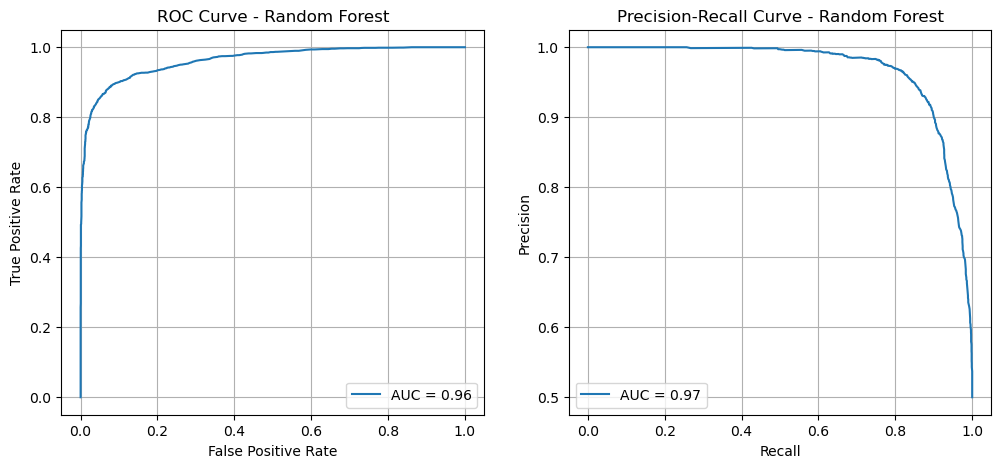


Évaluation du modèle : XGBoost
Seuil optimal choisi : 0.47
Confusion Matrix :
[[2613  211]
 [ 195 2629]]

Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2824
           1       0.93      0.93      0.93      2824

    accuracy                           0.93      5648
   macro avg       0.93      0.93      0.93      5648
weighted avg       0.93      0.93      0.93      5648



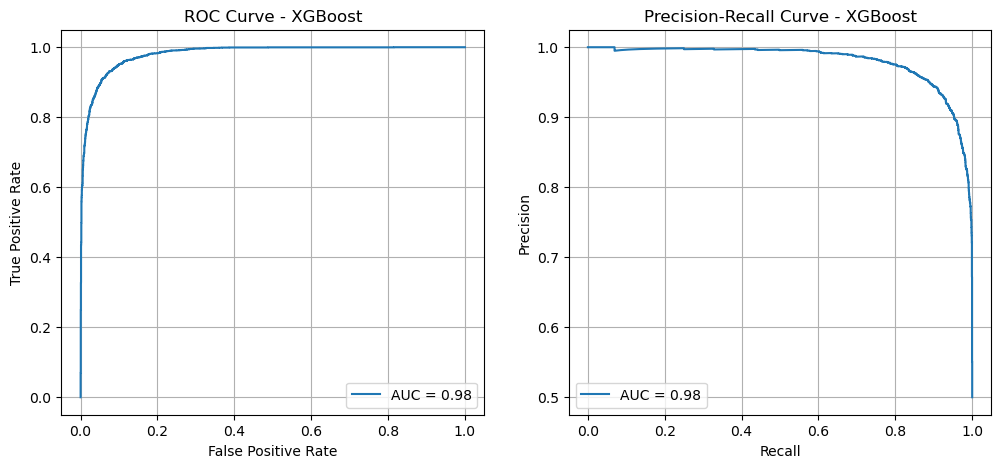

In [11]:
# Fonction pour ajuster le seuil de classification
def evaluate_model(model, X_test, y_test, model_name):
    y_probs = model.predict_proba(X_test)[:, 1]  # Probabilité d'être fraude
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
    
    # Choisir un seuil optimisé (maximiser recall sans trop baisser précision)
    best_threshold = thresholds_pr[np.argmax(2 * (precision * recall) / (precision + recall))]

    # Prédiction avec le seuil optimisé
    y_pred_opt = (y_probs >= best_threshold).astype(int)
    
    print(f"\nÉvaluation du modèle : {model_name}")
    print(f"Seuil optimal choisi : {best_threshold:.2f}")
    print("Confusion Matrix :")
    print(confusion_matrix(y_test, y_pred_opt))
    print("\nClassification Report :")
    print(classification_report(y_test, y_pred_opt))
    
    # Tracer la courbe ROC et la courbe Precision-Recall
    plt.figure(figsize=(12, 5))
    
    # Courbe ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid()

    # Courbe Precision-Recall
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"AUC = {auc(recall, precision):.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.legend()
    plt.grid()

    plt.show()

# Évaluer Random Forest
evaluate_model(best_rf, X_test, y_test, "Random Forest")

# Évaluer XGBoost
evaluate_model(best_xgb, X_test, y_test, "XGBoost")

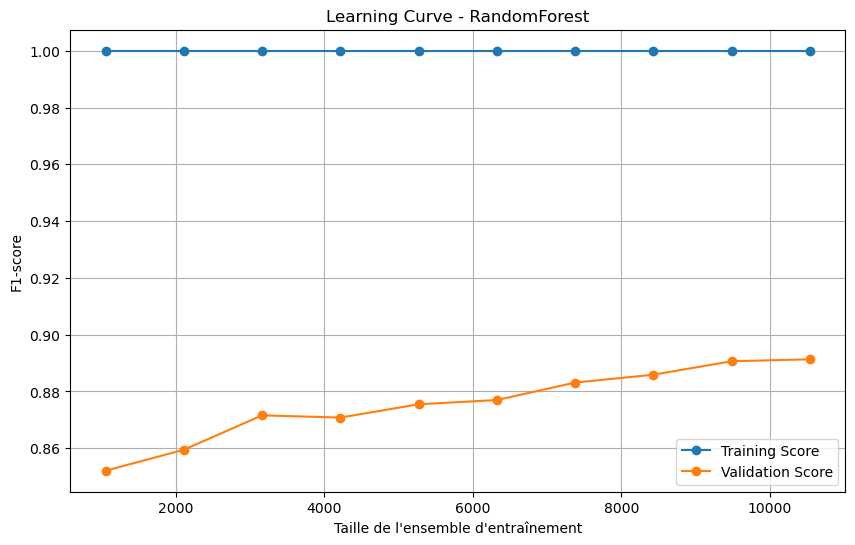

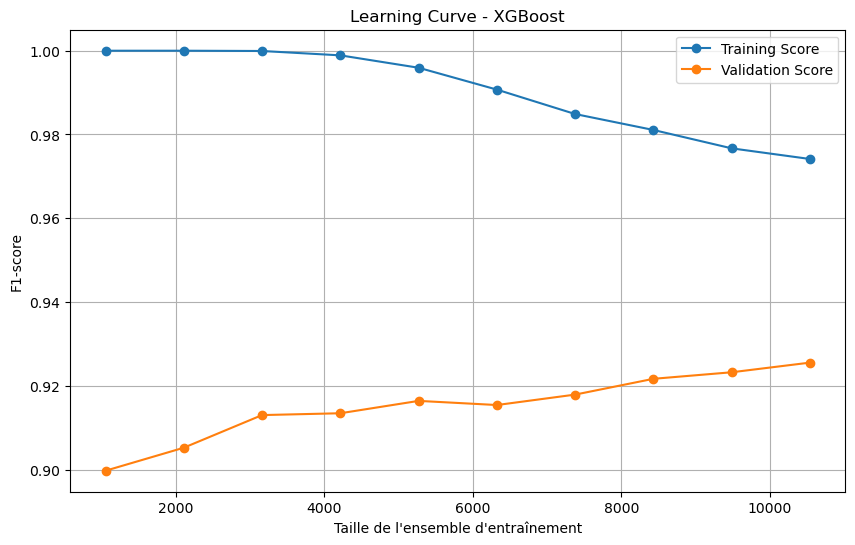

In [13]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, cv=5, scoring='f1', 
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
    plt.plot(train_sizes, np.mean(validation_scores, axis=1), 'o-', label='Validation Score')
    plt.title(title)
    plt.xlabel('Taille de l\'ensemble d\'entraînement')
    plt.ylabel('F1-score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Afficher Learning Curve pour RandomForest optimisé
plot_learning_curve(best_rf, X_train, y_train, "Learning Curve - RandomForest")

# Afficher Learning Curve pour XGBoost optimisé
plot_learning_curve(best_xgb, X_train, y_train, "Learning Curve - XGBoost")


In [15]:
# Transformer tout le dataset de cas pratiques
X_caspratique_transformed = best_xgb.steps[0][1].transform(X_caspratique)

# Prédire pour toutes les transactions
predictions = best_xgb.steps[-1][1].predict(X_caspratique_transformed)
probabilities = best_xgb.steps[-1][1].predict_proba(X_caspratique_transformed)[:, 1]

# Ajouter les résultats à un DataFrame pour l'affichage
resultats = X_caspratique.copy()
resultats['Vraie_Fraude'] = y_caspratique.values  # Valeur réelle de la fraude
resultats['Prediction_Fraude'] = predictions  # Prédiction du modèle
resultats['Probabilite_Fraude'] = probabilities  # Probabilité estimée

# Afficher les 20 transactions testées
display(resultats)

# Afficher le nombre d'erreurs (faux positifs et faux négatifs)
faux_positifs = ((predictions == 1) & (y_caspratique == 0)).sum()
faux_negatifs = ((predictions == 0) & (y_caspratique == 1)).sum()

print(f"Nombre de FAUX POSITIFS (transactions normales détectées comme fraudes) : {faux_positifs}")
print(f"Nombre de FAUX NÉGATIFS (fraudes non détectées) : {faux_negatifs}")


,ssn,cc_num,first,last,gender,city,state,zip,city_pop,job,...,trans_date,trans_time,unix_time,category,amt,merchant,id_transaction_type,Vraie_Fraude,Prediction_Fraude,Probabilite_Fraude
14297,198-47-7444,5566110627371588,James,Hansen,M,Silver Spring,MD,20901,282095,Radio producer,...,2023-09-08,23:30:52,1694196052,entertainment,502.17,fraud_Goldner-Lemke,5,1,1,0.918311
1264,096-65-8934,4581920487704,Jeffrey,Walters,M,Wallowa,OR,97885,1383,Waste management officer,...,2023-03-29,19:04:38,1680096878,entertainment,7.37,fraud_Johns Inc,5,1,0,0.129612
14622,400-67-6902,38524014843994,Tina,Brown,F,Somers,CT,6071,11645,Equities trader,...,2022-08-30,03:54:15,1661811855,shopping_pos,744.42,fraud_Turner and Sons,5,1,1,0.996267
13777,285-97-6907,4708053100330923275,Michael,Elliott,M,San Francisco,CA,94110,805301,Insurance risk surveyor,...,2023-12-01,03:06:32,1701380192,grocery_pos,317.02,fraud_Schoen,5,1,1,0.996309
15628,705-34-3347,502065562386,Justin,Schmidt,M,Ocala,FL,34475,207224,Therapist,...,2023-01-29,17:12:45,1674992565,shopping_net,1032.17,fraud_Romaguera,5,1,1,0.997778
12242,842-40-0346,4034864518376067,Timothy,Hardin,M,La Verne,CA,91750,33249,Regulatory affairs officer,...,2021-03-25,01:58:52,1616617732,grocery_net,317.50,fraud_Swift,5,1,1,0.990896
10631,267-26-0570,3511587605457698,Megan,Porter,F,Coolidge,AZ,85128,14823,Nurse,...,2023-05-14,03:33:01,1684015381,entertainment,763.20,fraud_Schaefer,5,1,1,0.995464
14979,676-56-8725,676340850954,Tammy,Solomon,F,Detroit,MI,48228,673342,Holiday representative,...,2021-05-04,00:56:12,1620069972,misc_net,848.99,fraud_Zemlak Group,5,1,1,0.996452
1522,713-18-7686,30010432898610,Ricardo,Young,M,Ogden,UT,84405,186422,Therapist,...,2022-12-23,03:04:01,1671744841,grocery_net,319.43,fraud_Emmerich-Luettgen,5,1,1,0.965867
12686,049-83-8060,30004093045413,Kimberly,Rollins,F,Clinton Township,MI,48035,96825,Engineer,...,2022-05-09,23:51:31,1652120491,home,19.35,fraud_Moore,5,1,1,0.599764


Nombre de FAUX POSITIFS (transactions normales détectées comme fraudes) : 1
Nombre de FAUX NÉGATIFS (fraudes non détectées) : 1


In [17]:
# Trouver la transaction de Krystal Branch
krystal_transaction = resultats[resultats['first'] == 'Krystal']

# Afficher ses détails
print(" Détails de la transaction de Krystal Branch :")
display(krystal_transaction)


 Détails de la transaction de Krystal Branch :


,ssn,cc_num,first,last,gender,city,state,zip,city_pop,job,...,trans_date,trans_time,unix_time,category,amt,merchant,id_transaction_type,Vraie_Fraude,Prediction_Fraude,Probabilite_Fraude
1532,441-23-1754,2623398454615676,Krystal,Branch,F,Louisville,KY,40214,736284,Banker,...,2022-11-13,19:30:33,1668348033,food_dining,281.15,fraud_Will Ltd,5,0,1,0.743613


In [19]:
# Définir un nouveau seuil de 80%
seuil = 0.80

# Appliquer la nouvelle règle de décision
resultats['Prediction_Fraude_80'] = (resultats['Probabilite_Fraude'] >= seuil).astype(int)

# Afficher le tableau avec l'ancienne et la nouvelle prédiction
print("Comparaison des prédictions avec seuil 50% et 80% :")
display(resultats[['Vraie_Fraude', 'Prediction_Fraude', 'Prediction_Fraude_80', 'Probabilite_Fraude']])

# Compter les erreurs avec le nouveau seuil
faux_positifs_80 = ((resultats['Prediction_Fraude_80'] == 1) & (resultats['Vraie_Fraude'] == 0)).sum()
faux_negatifs_80 = ((resultats['Prediction_Fraude_80'] == 0) & (resultats['Vraie_Fraude'] == 1)).sum()

print(f" Faux positifs avec seuil 80% : {faux_positifs_80}")
print(f" Faux négatifs avec seuil 80% : {faux_negatifs_80}")


Comparaison des prédictions avec seuil 50% et 80% :


,Vraie_Fraude,Prediction_Fraude,Prediction_Fraude_80,Probabilite_Fraude
14297,1,1,1,0.918311
1264,1,0,0,0.129612
14622,1,1,1,0.996267
13777,1,1,1,0.996309
15628,1,1,1,0.997778
12242,1,1,1,0.990896
10631,1,1,1,0.995464
14979,1,1,1,0.996452
1522,1,1,1,0.965867
12686,1,1,0,0.599764


 Faux positifs avec seuil 80% : 0
 Faux négatifs avec seuil 80% : 2


In [21]:
# Identifier les fraudes ratées (faux négatifs)
fraudes_ratees = resultats[(resultats['Vraie_Fraude'] == 1) & (resultats['Prediction_Fraude_80'] == 0)]

# Afficher les transactions concernées
print("🔍 Transactions frauduleuses non détectées avec seuil 80% :")
display(fraudes_ratees)


🔍 Transactions frauduleuses non détectées avec seuil 80% :


,ssn,cc_num,first,last,gender,city,state,zip,city_pop,job,...,trans_time,unix_time,category,amt,merchant,id_transaction_type,Vraie_Fraude,Prediction_Fraude,Probabilite_Fraude,Prediction_Fraude_80
1264,096-65-8934,4581920487704,Jeffrey,Walters,M,Wallowa,OR,97885,1383,Waste management officer,...,19:04:38,1680096878,entertainment,7.37,fraud_Johns Inc,5,1,0,0.129612,0
12686,049-83-8060,30004093045413,Kimberly,Rollins,F,Clinton Township,MI,48035,96825,Engineer,...,23:51:31,1652120491,home,19.35,fraud_Moore,5,1,1,0.599764,0


In [23]:
# Définir un nouveau seuil à 73%
seuil = 0.73

# Appliquer la nouvelle règle de décision
resultats['Prediction_Fraude_73'] = (resultats['Probabilite_Fraude'] >= seuil).astype(int)

# Afficher le tableau avec l'ancienne et la nouvelle prédiction
print("Comparaison des prédictions avec seuils 50%, 80% et 73% :")
display(resultats[['Vraie_Fraude', 'Prediction_Fraude', 'Prediction_Fraude_80', 'Prediction_Fraude_73', 'Probabilite_Fraude']])

# Compter les erreurs avec le nouveau seuil
faux_positifs_73 = ((resultats['Prediction_Fraude_73'] == 1) & (resultats['Vraie_Fraude'] == 0)).sum()
faux_negatifs_73 = ((resultats['Prediction_Fraude_73'] == 0) & (resultats['Vraie_Fraude'] == 1)).sum()

print(f" Faux positifs avec seuil 73% : {faux_positifs_73}")
print(f" Faux négatifs avec seuil 73% : {faux_negatifs_73}")



Comparaison des prédictions avec seuils 50%, 80% et 73% :


,Vraie_Fraude,Prediction_Fraude,Prediction_Fraude_80,Prediction_Fraude_73,Probabilite_Fraude
14297,1,1,1,1,0.918311
1264,1,0,0,0,0.129612
14622,1,1,1,1,0.996267
13777,1,1,1,1,0.996309
15628,1,1,1,1,0.997778
12242,1,1,1,1,0.990896
10631,1,1,1,1,0.995464
14979,1,1,1,1,0.996452
1522,1,1,1,1,0.965867
12686,1,1,0,0,0.599764


 Faux positifs avec seuil 73% : 1
 Faux négatifs avec seuil 73% : 2


In [25]:
# Définir un nouveau seuil à 76%
seuil = 0.76

# Appliquer la nouvelle règle de décision
resultats['Prediction_Fraude_76'] = (resultats['Probabilite_Fraude'] >= seuil).astype(int)

# Afficher le tableau avec l'ancienne et la nouvelle prédiction
print("Comparaison des prédictions avec seuils 50%, 80% et 76% :")
display(resultats[['Vraie_Fraude', 'Prediction_Fraude', 'Prediction_Fraude_80', 'Prediction_Fraude_76', 'Probabilite_Fraude']])

# Compter les erreurs avec le nouveau seuil
faux_positifs_76 = ((resultats['Prediction_Fraude_76'] == 1) & (resultats['Vraie_Fraude'] == 0)).sum()
faux_negatifs_76 = ((resultats['Prediction_Fraude_76'] == 0) & (resultats['Vraie_Fraude'] == 1)).sum()

print(f" Faux positifs avec seuil 76% : {faux_positifs_76}")
print(f" Faux négatifs avec seuil 76% : {faux_negatifs_76}")


Comparaison des prédictions avec seuils 50%, 80% et 76% :


,Vraie_Fraude,Prediction_Fraude,Prediction_Fraude_80,Prediction_Fraude_76,Probabilite_Fraude
14297,1,1,1,1,0.918311
1264,1,0,0,0,0.129612
14622,1,1,1,1,0.996267
13777,1,1,1,1,0.996309
15628,1,1,1,1,0.997778
12242,1,1,1,1,0.990896
10631,1,1,1,1,0.995464
14979,1,1,1,1,0.996452
1522,1,1,1,1,0.965867
12686,1,1,0,0,0.599764


 Faux positifs avec seuil 76% : 0
 Faux négatifs avec seuil 76% : 2


In [27]:
# Définir un nouveau seuil à 72%
seuil = 72 / 100  # Convertir en 0.72

# Appliquer la nouvelle règle de décision
resultats['Prediction_Fraude_72'] = (resultats['Probabilite_Fraude'] >= seuil).astype(int)

# Afficher les résultats avec les différents seuils
print("Comparaison des prédictions avec seuils 50%, 76%, et 72% :")
display(resultats[['Vraie_Fraude', 'Prediction_Fraude', 'Prediction_Fraude_76', 'Prediction_Fraude_72', 'Probabilite_Fraude']])

# Compter les erreurs avec le nouveau seuil
faux_positifs_72 = ((resultats['Prediction_Fraude_72'] == 1) & (resultats['Vraie_Fraude'] == 0)).sum()
faux_negatifs_72 = ((resultats['Prediction_Fraude_72'] == 0) & (resultats['Vraie_Fraude'] == 1)).sum()

print(f" Faux positifs avec seuil 72% : {faux_positifs_72}")
print(f" Faux négatifs avec seuil 72% : {faux_negatifs_72}")


Comparaison des prédictions avec seuils 50%, 76%, et 72% :


,Vraie_Fraude,Prediction_Fraude,Prediction_Fraude_76,Prediction_Fraude_72,Probabilite_Fraude
14297,1,1,1,1,0.918311
1264,1,0,0,0,0.129612
14622,1,1,1,1,0.996267
13777,1,1,1,1,0.996309
15628,1,1,1,1,0.997778
12242,1,1,1,1,0.990896
10631,1,1,1,1,0.995464
14979,1,1,1,1,0.996452
1522,1,1,1,1,0.965867
12686,1,1,0,0,0.599764


 Faux positifs avec seuil 72% : 1
 Faux négatifs avec seuil 72% : 2


 Meilleur seuil = 0.13 (F1-score = 0.95)


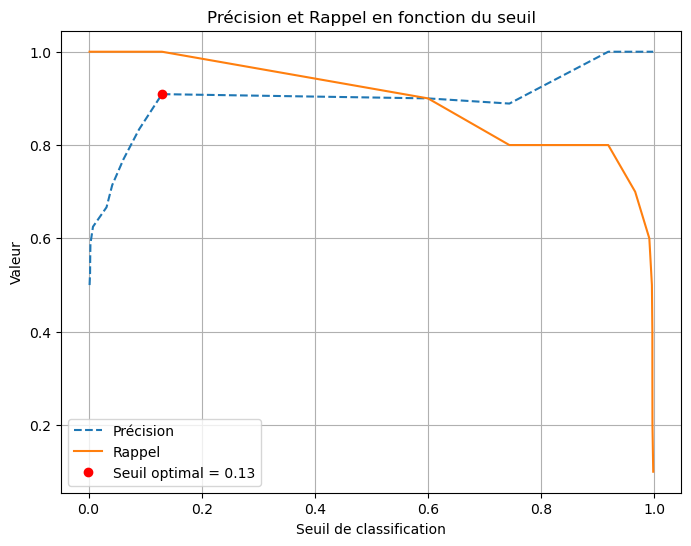

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Récupérer les probabilités des fraudes et les vraies valeurs
y_true = resultats['Vraie_Fraude']
y_probs = resultats['Probabilite_Fraude']

# Calculer la courbe précision-recall
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

# Calculer le F1-score pour chaque seuil
f1_scores = 2 * (precision * recall) / (precision + recall)

# Trouver le seuil qui maximise le F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

# Afficher le seuil optimal
print(f" Meilleur seuil = {best_threshold:.2f} (F1-score = {best_f1:.2f})")

# Afficher la courbe précision-recall avec le seuil optimal
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Précision", linestyle="--")
plt.plot(thresholds, recall[:-1], label="Rappel")
plt.plot(best_threshold, precision[np.argmax(f1_scores)], 'ro', label=f"Seuil optimal = {best_threshold:.2f}")
plt.xlabel("Seuil de classification")
plt.ylabel("Valeur")
plt.title("Précision et Rappel en fonction du seuil")
plt.legend()
plt.grid()
plt.show()


In [31]:
# Appliquer le seuil optimal trouvé (0.13)
seuil_optimal = 0.13
resultats['Prediction_Fraude_Optimal'] = (resultats['Probabilite_Fraude'] >= seuil_optimal).astype(int)

# Compter les erreurs
faux_positifs_optimal = ((resultats['Prediction_Fraude_Optimal'] == 1) & (resultats['Vraie_Fraude'] == 0)).sum()
faux_negatifs_optimal = ((resultats['Prediction_Fraude_Optimal'] == 0) & (resultats['Vraie_Fraude'] == 1)).sum()

# Afficher les résultats
print(f" Faux positifs avec seuil optimal ({seuil_optimal}) : {faux_positifs_optimal}")
print(f" Faux négatifs avec seuil optimal ({seuil_optimal}) : {faux_negatifs_optimal}")


 Faux positifs avec seuil optimal (0.13) : 1
 Faux négatifs avec seuil optimal (0.13) : 1


In [33]:
for seuil in [0.15, 0.20]:
    resultats[f'Prediction_Fraude_{int(seuil*100)}'] = (resultats['Probabilite_Fraude'] >= seuil).astype(int)
    
    faux_positifs = ((resultats[f'Prediction_Fraude_{int(seuil*100)}'] == 1) & (resultats['Vraie_Fraude'] == 0)).sum()
    faux_negatifs = ((resultats[f'Prediction_Fraude_{int(seuil*100)}'] == 0) & (resultats['Vraie_Fraude'] == 1)).sum()
    
    print(f"\n Test du seuil {seuil}:")
    print(f" Faux positifs : {faux_positifs}")
    print(f" Faux négatifs : {faux_negatifs}")



 Test du seuil 0.15:
 Faux positifs : 1
 Faux négatifs : 1

 Test du seuil 0.2:
 Faux positifs : 1
 Faux négatifs : 1


In [35]:
# Définir le seuil à 0.6
seuil_06 = 0.6

# Appliquer la nouvelle règle de décision
resultats['Prediction_Fraude_06'] = (resultats['Probabilite_Fraude'] >= seuil_06).astype(int)

# Compter les erreurs
faux_positifs_06 = ((resultats['Prediction_Fraude_06'] == 1) & (resultats['Vraie_Fraude'] == 0)).sum()
faux_negatifs_06 = ((resultats['Prediction_Fraude_06'] == 0) & (resultats['Vraie_Fraude'] == 1)).sum()

# Afficher les résultats
print(f" Faux positifs avec seuil 0.6 : {faux_positifs_06}")
print(f" Faux négatifs avec seuil 0.6 : {faux_negatifs_06}")


 Faux positifs avec seuil 0.6 : 1
 Faux négatifs avec seuil 0.6 : 2
